In [11]:
import os
import random
from tqdm.notebook import tqdm

import numpy as np
import pandas as pd


from sklearn.preprocessing import LabelEncoder, OrdinalEncoder, OneHotEncoder
from sklearn.preprocessing import StandardScaler, MinMaxScaler, PowerTransformer, QuantileTransformer
from sklearn.compose import make_column_transformer
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split

import seaborn as sns
import matplotlib.pyplot as plt

ROOT_DIR = "./data"
RANDOM_SEED = 110

np.random.seed(RANDOM_SEED)
%matplotlib inline

In [4]:
# read csv
df_tr = pd.read_csv(os.path.join(ROOT_DIR, "train_v1.csv"))
df_te = pd.read_csv(os.path.join(ROOT_DIR, "test_v1.csv"))
df_list = [df_tr, df_te]

### Scaling & Encoding

In [5]:
cat_cols = ["Equipment_Dam",
                       "Chamber Temp. Judge Value_AutoClave",
                       "Equipment_Fill1",
                       "Equipment_Fill2",
                       "Model.Suffix",
                       "Workorder",
                       "Workorder Category",
                       "DISCHARGED TIME OF RESIN(Stage1) Collect Result Bins_Dam",
                       "DISCHARGED TIME OF RESIN(Stage2) Collect Result Bins_Dam",
                       "DISCHARGED TIME OF RESIN(Stage3) Collect Result Bins_Dam",
                       "Dispense Volume(Stage1) Collect Result Bins_Dam",
                       "Dispense Volume(Stage2) Collect Result Bins_Dam",
                       "Dispense Volume(Stage3) Collect Result Bins_Dam",
                       "HEAD NORMAL COORDINATE X AXIS(Stage2) Collect Result Bins_Dam",
                       "HEAD NORMAL COORDINATE X AXIS(Stage3) Collect Result Bins_Dam",
                       "HEAD NORMAL COORDINATE Y AXIS(Stage1) Collect Result Bins_Dam",
                       "HEAD NORMAL COORDINATE Y AXIS(Stage2) Collect Result Bins_Dam",
                       "HEAD NORMAL COORDINATE Y AXIS(Stage3) Collect Result Bins_Dam",
                       "HEAD NORMAL COORDINATE Z AXIS(Stage1) Collect Result Bins_Dam",
                       "HEAD NORMAL COORDINATE Z AXIS(Stage2) Collect Result Bins_Dam",
                       "HEAD NORMAL COORDINATE Z AXIS(Stage3) Collect Result Bins_Dam",
                       "HEAD Standby Position X Collect Result Bins_Dam",
                       "Machine Tact time Collect Result Bins_Dam",
                       "PalletID Collect Result Bins_Dam",
                       "Production Qty Collect Result Bins_Dam",
                       "Receip No Collect Result Bins_Dam",
                       "DISCHARGED TIME OF RESIN(Stage1) Collect Result Bins_Fill1",
                       "DISCHARGED TIME OF RESIN(Stage2) Collect Result Bins_Fill1",
                       "DISCHARGED TIME OF RESIN(Stage3) Collect Result Bins_Fill1",
                       "Dispense Volume(Stage1) Collect Result Bins_Fill1",
                       "Dispense Volume(Stage2) Collect Result Bins_Fill1",
                       "Dispense Volume(Stage3) Collect Result Bins_Fill1",
                       "HEAD NORMAL COORDINATE X AXIS(Stage2) Collect Result Bins_Fill1",
                       "HEAD NORMAL COORDINATE X AXIS(Stage3) Collect Result Bins_Fill1",
                       "HEAD NORMAL COORDINATE Y AXIS(Stage1) Collect Result Bins_Fill1",
                       "HEAD NORMAL COORDINATE Y AXIS(Stage2) Collect Result Bins_Fill1",
                       "HEAD NORMAL COORDINATE Y AXIS(Stage3) Collect Result Bins_Fill1",
                       "HEAD NORMAL COORDINATE Z AXIS(Stage1) Collect Result Bins_Fill1",
                       "HEAD NORMAL COORDINATE Z AXIS(Stage2) Collect Result Bins_Fill1",
                       "HEAD NORMAL COORDINATE Z AXIS(Stage3) Collect Result Bins_Fill1",
                       "HEAD Standby Position X Collect Result Bins_Fill1",
                       "Machine Tact time Collect Result Bins_Fill1",
                       "PalletID Collect Result Bins_Fill1",
                       "Production Qty Collect Result Bins_Fill1",
                       "Receip No Collect Result Bins_Fill1",
                       "Machine Tact time Collect Result Bins_Fill2",
                       "PalletID Collect Result Bins_Fill2",
                       "Production Qty Collect Result Bins_Fill2",
                       "Receip No Collect Result Bins_Fill2"]

In [6]:
for df in df_list:
    df[cat_cols] = df[cat_cols].astype("category")

In [7]:
num_cols = df_tr.select_dtypes(exclude=["category"]).columns.to_list()
num_cols.remove("target")

In [41]:
all_cols = num_cols + cat_cols

In [8]:
# 우리가 파악해야하는 건 AbNormal이므로 1로 설정
df_tr["target"] = df_tr["target"].map({"Normal": 0, "AbNormal": 1})
# df_tr["target"] = df_tr["target"].map({0:"Normal", 1:"AbNormal"})

In [9]:
X_tr = df_tr.drop("target", axis=1)
y_tr = df_tr["target"]

X_te = df_te.drop("Set ID", axis=1)
set_id = df_te["Set ID"]

In [33]:
ct = make_column_transformer(
    (MinMaxScaler(), num_cols),
    (OneHotEncoder(handle_unknown="ignore", sparse=False), cat_cols),
    remainder="passthrough",
)

X_tr_trans = ct.fit_transform(X_tr)
X_te_trans = ct.transform(X_te)

In [34]:
X_tr_trans.shape # 열 174 -> 983 (OneHot)

(38407, 983)

In [35]:
ohe = ct.transformers_[1][1]
ohe_cat_cols = ohe.get_feature_names_out(cat_cols)

In [40]:
ohe_all_cols = num_cols + list(ohe_cat_cols)

### Resampling

In [14]:
df_org = df_tr.copy()

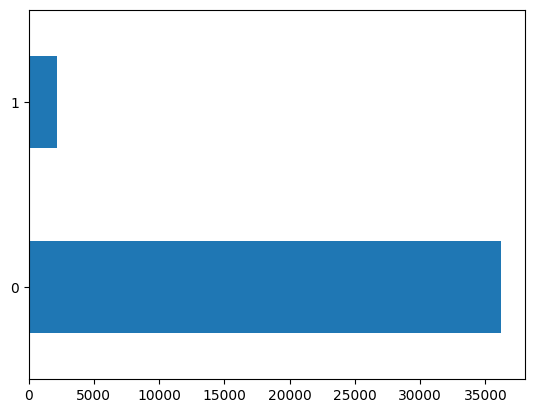

In [15]:
df_tr["target"].value_counts().plot(kind="barh");

In [56]:
from sklearn.utils import resample
from imblearn.under_sampling import NearMiss
from imblearn.under_sampling import ClusterCentroids
from imblearn.under_sampling import AllKNN
from imblearn.under_sampling import OneSidedSelection
from imblearn.under_sampling import TomekLinks

def random_downsample(df, sample_ratio=1.0, random_seed=RANDOM_SEED):
    df_normal = df[df["target"] == 0] 
    df_abnormal = df[df["target"] == 1]
    
    downsampled = resample(
        df_normal,
        replace=False,
        n_samples=int(len(df_abnormal) * sample_ratio),
        random_state=random_seed
    )
    
    downsampled_df = pd.concat([df_abnormal, downsampled])
    
    return downsampled_df

def downsample(X, y, method, random_seed=RANDOM_SEED):
    # NearMiss
    if method == "nearmiss":
        nm = NearMiss(sampling_strategy=0.5)
        X_downsampled, y_downsampled = nm.fit_resample(X, y)
    # ClusterCentroids
    elif method == "cluster":
        cc = ClusterCentroids(random_state=random_seed)
        X_downsampled, y_downsampled = cc.fit_resample(X, y)
    # AllKNN
    elif method == "allknn":
        allknn = AllKNN(random_state=random_seed)
        X_downsampled, y_downsampled = allknn.fit_resample(X, y)
    # OneSidedSelection
    elif method == "oneside":
        oss = OneSidedSelection(random_state=random_seed)
        X_downsampled, y_downsampled = oss.fit_resample(X, y)
    # Tomeklinks
    elif method == "tomek":
        tl = TomekLinks(random_state=random_seed)
        X_downsampled, y_downsampled = tl.fit_resample(X, y)
    
    X_downsampled_df= pd.DataFrame(X_downsampled, columns=ohe_all_cols)   
    y_downsampled_df = pd.Series(y_downsampled, name="target")
    downsampled_df = pd.concat([X_downsampled_df, y_downsampled_df], axis=1)
    
    return downsampled_df 

In [57]:
X_tr_trans.shape

(38407, 983)

In [58]:
y_tr.shape

(38407,)

In [59]:
# downsampled_df = random_downsample(df, sample_ratio=3.0)
downsample_options = {1:"nearmiss", 2:"cluster", 3:"allknn", 4:"oneside", 5:"tomek"}

downsampled_df_tr = downsample(X_tr_trans, y_tr, method=downsample_options[1])

In [60]:
downsampled_df_tr.head()

,CURE END POSITION X Collect Result_Dam,CURE END POSITION Z Collect Result_Dam,CURE SPEED Collect Result_Dam,CURE START POSITION X Collect Result_Dam,CURE START POSITION Θ Collect Result_Dam,DISCHARGED SPEED OF RESIN Collect Result_Dam,DISCHARGED TIME OF RESIN(Stage1) Collect Result_Dam,DISCHARGED TIME OF RESIN(Stage2) Collect Result_Dam,DISCHARGED TIME OF RESIN(Stage3) Collect Result_Dam,Dispense Volume(Stage1) Collect Result_Dam,...,Receip No Collect Result Bins_Fill2_1.0,Receip No Collect Result Bins_Fill2_2.0,Receip No Collect Result Bins_Fill2_3.0,Receip No Collect Result Bins_Fill2_4.0,Receip No Collect Result Bins_Fill2_5.0,Receip No Collect Result Bins_Fill2_6.0,Receip No Collect Result Bins_Fill2_7.0,Receip No Collect Result Bins_Fill2_8.0,Receip No Collect Result Bins_Fill2_9.0,target
0,0.0,0.0,0.000000,1.0,0.0,0.0,0.000000,0.014706,0.008475,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
1,1.0,1.0,0.428571,0.0,1.0,1.0,0.452991,0.705882,0.432203,0.574850,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
2,1.0,1.0,0.428571,0.0,1.0,1.0,0.452991,0.691176,0.432203,0.574850,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
3,1.0,1.0,0.000000,0.0,1.0,0.0,1.000000,0.985294,0.991525,0.491018,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
4,0.0,0.0,0.000000,1.0,0.0,0.0,0.008547,0.014706,0.008475,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0


In [61]:
downsampled_df_tr.info() 

# 38407 entries (original) 
# 4700 entries (sample ratio=1.0)
# 7050 entries (sample_ratio=2.0)
# 9400 entries (sample_ratio=3.0) (Selected)
# 11750 entries (sample_ratio=4.0)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6630 entries, 0 to 6629
Columns: 984 entries, CURE END POSITION X Collect Result_Dam to target
dtypes: float64(983), int64(1)
memory usage: 49.8 MB


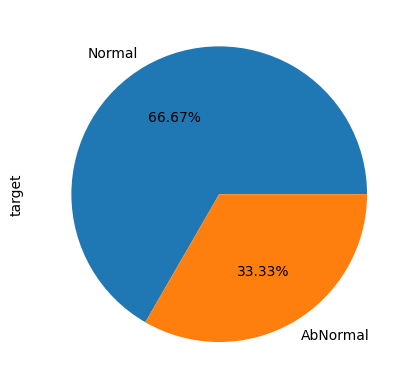

In [62]:
downsampled_df_tr["target"].value_counts().plot.pie(labels=["Normal", "AbNormal"], autopct=lambda x:f"{x:.2f}%");

In [76]:
downsampled_df_tr.columns

Index(['CURE END POSITION X Collect Result_Dam',
       'CURE END POSITION Z Collect Result_Dam',
       'CURE SPEED Collect Result_Dam',
       'CURE START POSITION X Collect Result_Dam',
       'CURE START POSITION Θ Collect Result_Dam',
       'DISCHARGED SPEED OF RESIN Collect Result_Dam',
       'DISCHARGED TIME OF RESIN(Stage1) Collect Result_Dam',
       'DISCHARGED TIME OF RESIN(Stage2) Collect Result_Dam',
       'DISCHARGED TIME OF RESIN(Stage3) Collect Result_Dam',
       'Dispense Volume(Stage1) Collect Result_Dam',
       ...
       'Receip No Collect Result Bins_Fill2_1.0',
       'Receip No Collect Result Bins_Fill2_2.0',
       'Receip No Collect Result Bins_Fill2_3.0',
       'Receip No Collect Result Bins_Fill2_4.0',
       'Receip No Collect Result Bins_Fill2_5.0',
       'Receip No Collect Result Bins_Fill2_6.0',
       'Receip No Collect Result Bins_Fill2_7.0',
       'Receip No Collect Result Bins_Fill2_8.0',
       'Receip No Collect Result Bins_Fill2_9.0', 'targ

In [83]:
from imblearn.over_sampling import SMOTE
from imblearn.over_sampling import ADASYN
from imblearn.over_sampling import SMOTENC
from imblearn.over_sampling import BorderlineSMOTE
from imblearn.over_sampling import KMeansSMOTE

from imblearn.combine import SMOTEENN

def upsample(df, cat_idx, method, random_seed=RANDOM_SEED):
    X = df.drop("target", axis=1)
    y = df["target"]
    
    # SMOTE
    if method == "smote":
        smote = SMOTE(random_state=random_seed)
        X_upsampled, y_upsampled = smote.fit_resample(X, y)
    # ADASYN
    elif method == "adasyn":
        adasyn = ADASYN(random_state=random_seed)
        X_upsampled, y_upsampled = adasyn.fit_resample(X, y)
    # SMOTE-NC (both numerical & categorical features)
    elif method == "smotenc":
        smotenc = SMOTENC(random_state=random_seed, categorical_features=cat_idx)
        X_upsampled, y_upsampled = smotenc.fit_resample(X, y)
    elif method == "borderline":
        borderline_smote = BorderlineSMOTE(random_state=random_seed)
        X_upsampled, y_upsampled = borderline_smote.fit_resample(X, y)
    elif method == "kmeans":
        kmeans_smote = KMeansSMOTE(random_state=random_seed)
        X_upsampled, y_upsampled = kmeans_smote.fit_resample(X, y)
        
    X_upsampled_df= pd.DataFrame(X_upsampled, columns=X_tr.columns)   
    y_upsampled_df = pd.Series(y_upsampled, name="target")
    upsampled_df = pd.concat([X_upsampled_df, y_upsampled_df])
    
    return upsampled_df

In [85]:
upsample_options = {1:"smote", 2:"adasyn", 3:"smotenc", 4:"borderline", 5:"kmeans"}

cat_idx = [downsampled_df_tr.columns.get_loc(col) for col in ohe_cat_cols]
upsampled_df = upsample(downsampled_df_tr, cat_idx, method=upsample_options[3])

In [86]:
upsampled_df.head()

,Equipment_Dam,CURE END POSITION X Collect Result_Dam,CURE END POSITION Z Collect Result_Dam,CURE SPEED Collect Result_Dam,CURE START POSITION X Collect Result_Dam,CURE START POSITION Θ Collect Result_Dam,DISCHARGED SPEED OF RESIN Collect Result_Dam,DISCHARGED TIME OF RESIN(Stage1) Collect Result_Dam,DISCHARGED TIME OF RESIN(Stage2) Collect Result_Dam,DISCHARGED TIME OF RESIN(Stage3) Collect Result_Dam,...,HEAD Standby Position X Collect Result Bins_Fill1,Machine Tact time Collect Result Bins_Fill1,PalletID Collect Result Bins_Fill1,Production Qty Collect Result Bins_Fill1,Receip No Collect Result Bins_Fill1,Machine Tact time Collect Result Bins_Fill2,PalletID Collect Result Bins_Fill2,Production Qty Collect Result Bins_Fill2,Receip No Collect Result Bins_Fill2,0
0,NaN,0.0,0.0,0.000000,1.0,0.0,0.0,0.000000,0.014706,0.008475,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,1.0,1.0,0.428571,0.0,1.0,1.0,0.452991,0.705882,0.432203,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,1.0,1.0,0.428571,0.0,1.0,1.0,0.452991,0.691176,0.432203,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,1.0,1.0,0.000000,0.0,1.0,0.0,1.000000,0.985294,0.991525,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,0.0,0.0,0.000000,1.0,0.0,0.0,0.008547,0.014706,0.008475,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
downsampled_df_tr["target"].value_counts().plot.pie(labels=["Normal", "AbNormal"], autopct=lambda x:f"{x:.2f}%");